# SECS example

In this example we specify the (radial) curl of the equivalent current in space, and show the corresponding current and magnetic field


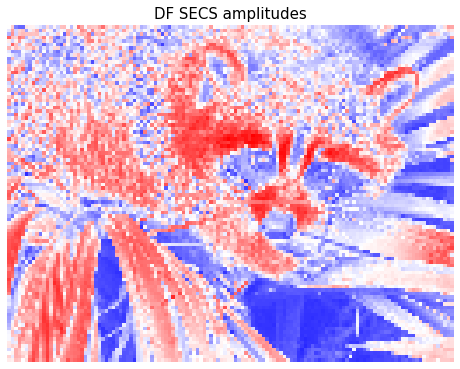

In [2]:
%matplotlib inline
from secsy import cubedsphere as cs
from secsy import get_SECS_J_G_matrices, get_SECS_B_G_matrices
import numpy as np
from scipy.misc import face
import matplotlib.pyplot as plt


# load a picture to represent the SECS divergence-free amplitude (the curl of the current)
I = face(gray = True)[::8, ::8][::-1] # downsample and turn upside-down
shp = I.shape
I = I - I.mean()

# set up cubed sphere projection and grid
projection = cs.CSprojection((-105, 80), 90) # central (lon, lat) and orientation of the grid
grid = cs.CSgrid(projection, shp[1] * 1e4, shp[0]*1e4, shp[0], shp[1], R = 6371.2e3, wshift = 1e3)

fig, ax = plt.subplots(figsize = (8, 7))
ax.pcolormesh(grid.xi_mesh, grid.eta_mesh, I, cmap = plt.cm.bwr, vmin = -np.abs(I.max()), vmax = np.abs(I.max()))
ax.set_axis_off()
ax.set_aspect('equal')
ax.set_title('DF SECS amplitudes', size = 15)
plt.show()

In [3]:
# set up an evaluation grid - note that we use grid.lon_mesh and grid.lat_mesh, which are offset from
# grid.lon and grid.lat. This avoids singularities. 
ss = slice(0, -1, 7) # downsample for vector plots
la, lo = grid.lat_mesh[ss, ss], grid.lon_mesh[ss, ss]

# matrices that calculate currents:
Gej, Gnj = get_SECS_J_G_matrices(la, lo, grid.lat, grid.lon) 
# and magnetic field on ground (evaluated on the full "mesh" grid, not downsampled):
GeB, GnB, GuB = get_SECS_B_G_matrices(grid.lat_mesh, grid.lon_mesh, 6371.2e3, grid.lat, grid.lon)

# Use matrices to calculate the actual values:
I = I.flatten()
je, jn = Gej.dot(I).reshape(la.shape), Gnj.dot(I).reshape(la.shape)
Be, Bn, Bu = GeB.dot(I).reshape(grid.lat_mesh.shape), GnB.dot(I).reshape(grid.lat_mesh.shape), GuB.dot(I).reshape(grid.lat_mesh.shape)



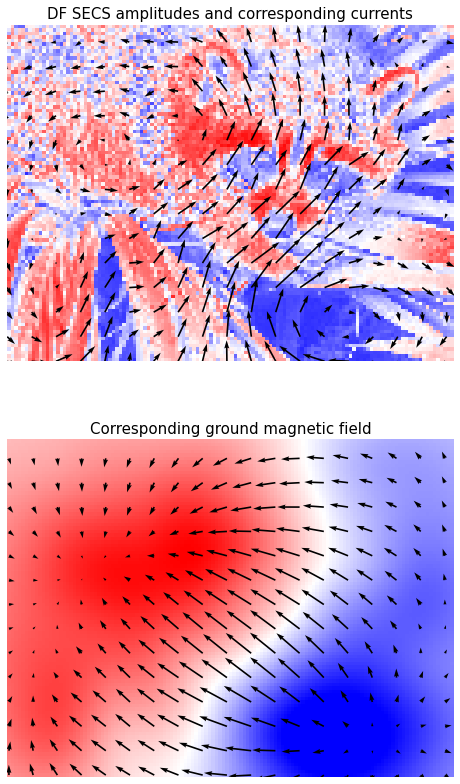

In [4]:
fig, ax = plt.subplots(nrows = 2, figsize = (8, 14))
x, y, Ax, Ay = projection.vector_cube_projection(je, jn, lo, la, return_xi_eta = True)
ax[0].pcolormesh(grid.xi_mesh, grid.eta_mesh, I.reshape(shp), cmap = plt.cm.bwr, vmin = -np.abs(I.max()), vmax = np.abs(I.max()))
ax[0].set_axis_off()
ax[0].set_aspect('equal')
ax[0].quiver(x, y, Ax, Ay)
ax[0].set_title('DF SECS amplitudes and corresponding currents', size = 15)

x, y, Ax, Ay = projection.vector_cube_projection(Be[ss, ss].flatten(), Bn[ss, ss].flatten(), lo, la, return_xi_eta = True)
ax[1].pcolormesh(grid.xi_mesh, grid.eta_mesh, Bu, cmap = plt.cm.bwr, vmin = -np.abs(Bu.max()), vmax = np.abs(Bu.max()))
ax[1].set_axis_off()
ax[1].set_aspect('equal')
ax[1].quiver(x, y, Ax, Ay)
ax[1].set_title('Corresponding ground magnetic field', size = 15)

plt.show()